# Amazon Nova for image grounding

Amazon have a strong ability for image grounding task, include open world and screenshots.

The output bounding box in in scale [1, 1000], that you need to rescale the model output coordinates the original image size.

Here are some examples.

In [1]:
!pip install Pillow boto3

## Invoke Nova via bedrock converse api

In [2]:
import io
import json

from PIL import Image, ImageDraw
import boto3


class Assistant:
    def __init__(self, base_prompts, prefill="", model_id="us.amazon.nova-lite-v1:0"):
        self.model_id = model_id
        self.bedrock_client = boto3.client(service_name="bedrock-runtime")
        self.base_prompts = base_prompts
        self.prefill = prefill

    def generate(self, image_pil, **kwargs):
        prompts = self.base_prompts
        for k, v in kwargs.items():
            prompts = prompts.replace("{{" + k + "}}", v)

        buffer = io.BytesIO()
        image_pil.save(buffer, format="webp", quality=80)  # quality: 75 by default | 100 for lossless compression
        image_data = buffer.getvalue()
        
        messages = [
            {
                "role": "user",
                "content": [
                    {
                        "image": {
                            "format": 'webp',
                            "source": {
                                "bytes": image_data,
                            }
                        }
                    },
                    {
                        "text": prompts
                    },
                ],
            },
        ]
        
        if self.prefill:
            messages.append({
                "role": "assistant",
                "content": [
                    {"text": self.prefill},
                ],
            })

        response = self.bedrock_client.converse_stream(
            modelId=self.model_id, messages=messages,
            inferenceConfig={
                "temperature": 0.0,
                "topP": 0.0,
                "maxTokens": 4096,
            },
        )
        output = []
        print(self.model_id, "response")
        print(self.prefill, end='')
        for event in response.get('stream'):
            if 'contentBlockDelta' in event:
                out = event['contentBlockDelta']['delta']['text']
                print(out, end='', flush=True)
                output.append(out)
        print()
        result = self.prefill + "".join(output)
        return result

## Detection task

In [3]:
def detection(prompts, image_path, label, prefill):
    
    assistant = Assistant(base_prompts=prompts, prefill=prefill, model_id="us.amazon.nova-lite-v1:0")

    image_pil = Image.open(image_path)
    
    result = assistant.generate(image_pil, label=label)
    result = result.replace("(", "[").replace(")", "]")
    bboxs = json.loads(result)
    if not isinstance(bboxs[0], list):
        bboxs = [bboxs]
    for bbox in bboxs:
        x1, y1, x2, y2 = bbox
        if x1 >= x2 or y1 >= y2:
            continue
        w, h = image_pil.size
        x1 = x1 / 1000 * w
        x2 = x2 / 1000 * w
        y1 = y1 / 1000 * h
        y2 = y2 / 1000 * h
        bbox = (x1, y1, x2, y2)
        bbox = list(map(round, bbox))
        print(f"detect <{label}> in {bbox}")
        # draw bounding box
        draw = ImageDraw.Draw(image_pil)
        draw.rectangle(bbox, outline="red", width=2)
    display(image_pil)

### Open world object detection

us.amazon.nova-lite-v1:0 response
[(391, 182, 647, 809)]
detect <bottle> in [200, 93, 331, 414]


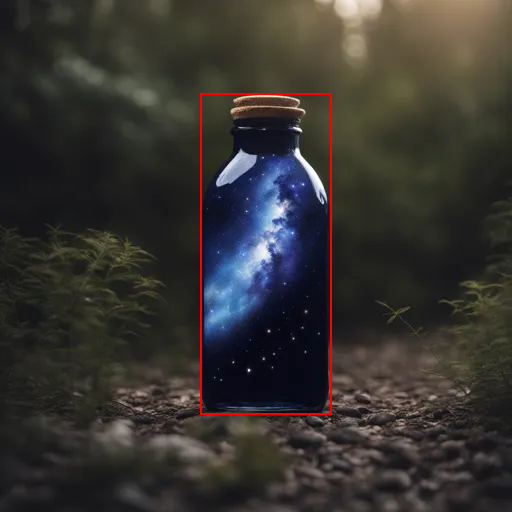

In [4]:
detection_prompts = """
Detect bounding box of <{{label}}> in the image, output in a list of (x1, y1, x2, y2) format.
"""

detection(
    prompts=detection_prompts,
    prefill="[(",
    image_path="test_images/bottle_image.webp", 
    label="bottle"
)

us.amazon.nova-lite-v1:0 response
[(65, 204, 280, 449)]
detect <yellow car> in [52, 122, 224, 269]


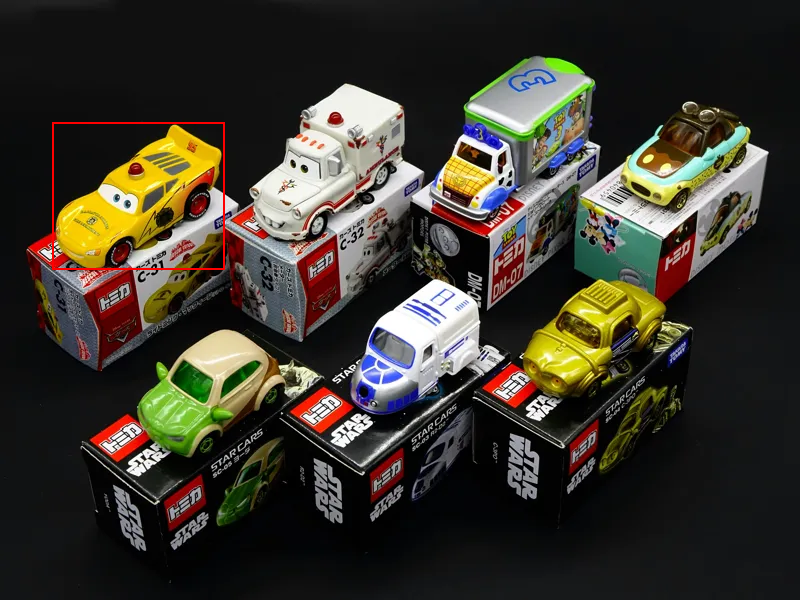

In [5]:
# url = "https://images.pexels.com/photos/163696/toy-car-toy-box-mini-163696.jpeg"

detection(
    prompts=detection_prompts,
    prefill="[(",
    image_path="test_images/toys.webp", 
    label="yellow car"
)

us.amazon.nova-lite-v1:0 response
[(524, 734, 716, 967), [753, 714, 940, 944), [524, 573, 692, 781), [738, 565, 895, 750), [291, 553, 463, 745), [291, 700, 483, 958), [60, 719, 251, 968), [64, 568, 250, 760)]
detect <cake> in [419, 440, 573, 580]
detect <cake> in [602, 428, 752, 566]
detect <cake> in [419, 344, 554, 469]
detect <cake> in [590, 339, 716, 450]
detect <cake> in [233, 332, 370, 447]
detect <cake> in [233, 420, 386, 575]
detect <cake> in [48, 431, 201, 581]
detect <cake> in [51, 341, 200, 456]


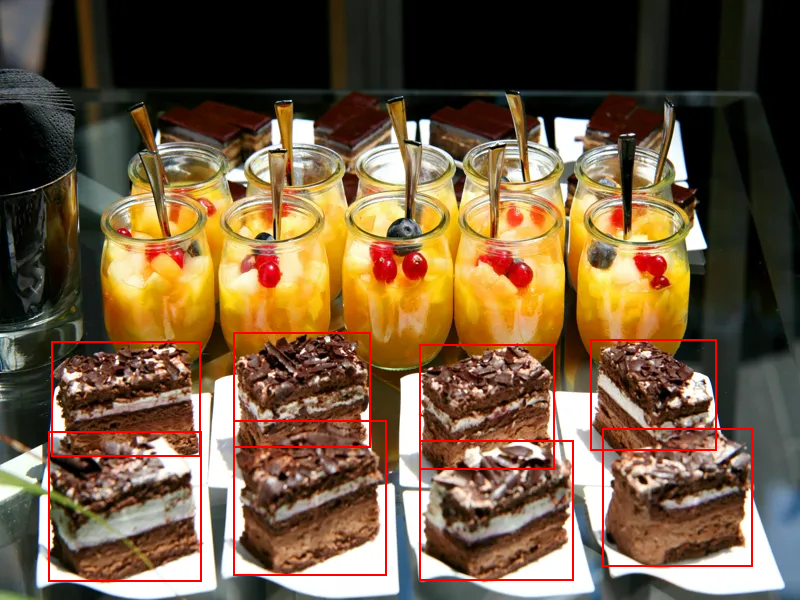

In [6]:
# https://images.pexels.com/photos/88917/pexels-photo-88917.jpeg

detection(
    prompts=detection_prompts,
    prefill="[(",
    image_path="test_images/cakes.webp", 
    label="cake",
)

### Screenshot UI grounding

us.amazon.nova-lite-v1:0 response
(754, 28, 769, 49)
detect <compare mode switch> in [679, 19, 692, 33]


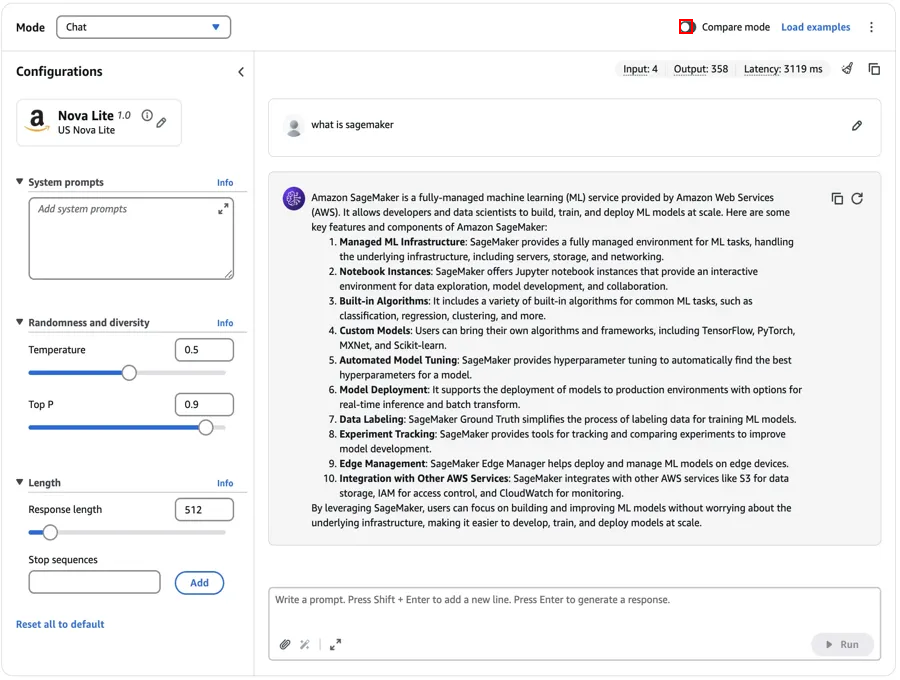

us.amazon.nova-lite-v1:0 response
(902, 929, 972, 962)
detect <Run button> in [812, 632, 875, 654]


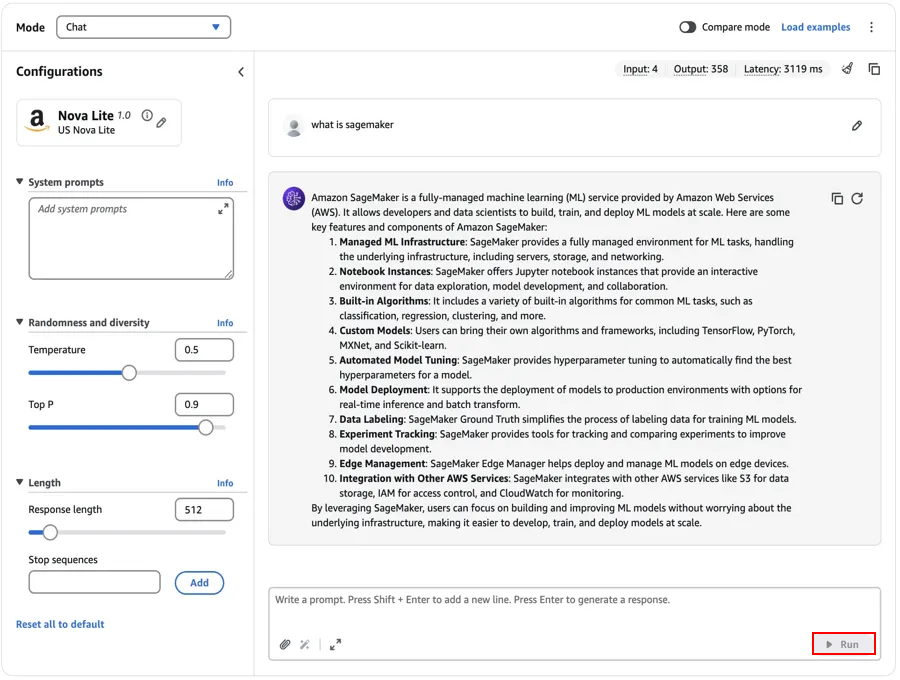

In [7]:
prompts = "extract bounding box of the <{{label}}> in the image, output format is [x1, y1, x2, y2]"

detection(
    prompts=prompts,
    prefill="(",
    image_path="test_images/bedrock_playground_screenshot.webp", 
    label="compare mode switch"
)

detection(
    prompts=prompts,
    prefill="(",
    image_path="test_images/bedrock_playground_screenshot.webp", 
    label="Run button"
)

## VQA in the bounding box

In [8]:
def caption(prompts, image_path, bbox):
    image_pil = Image.open(image_path)
    draw = ImageDraw.Draw(image_pil)
    draw.rectangle(bbox, outline="red", width=2)
    display(image_pil)
    
    x1, y1, x2, y2 = bbox
    w, h = image_pil.size
    x1 = x1 / w * 1000
    x2 = x2 / w * 1000
    y1 = y1 / h * 1000
    y2 = y2 / h * 1000
    bbox = (x1, y1, x2, y2)
    bbox = list(map(round, bbox))
    bbox = str(tuple(bbox))

    print("Question:", prompts)
    
    assistant = Assistant(base_prompts=prompts, model_id="us.amazon.nova-lite-v1:0")

    image_pil = Image.open(image_path)
    
    result = assistant.generate(image_pil, bbox=bbox)

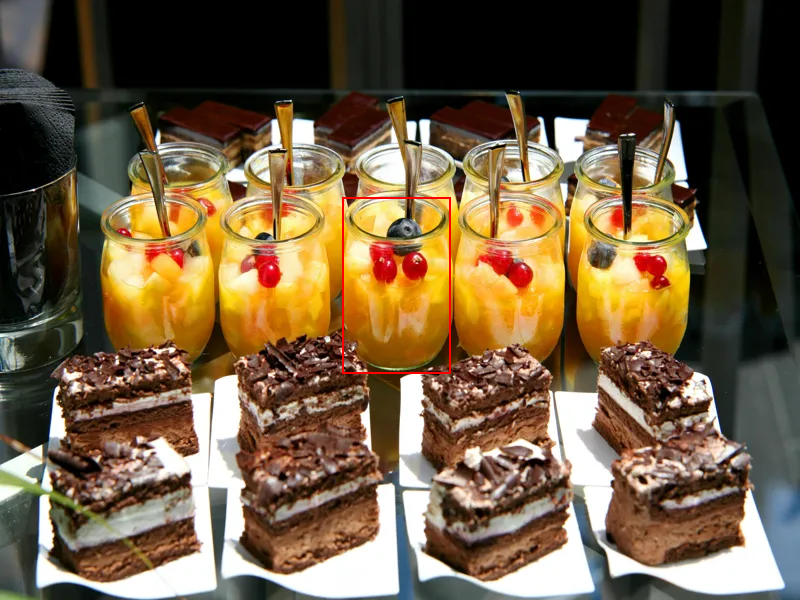

Question: Describe the object in bounding box {{bbox}}
us.amazon.nova-lite-v1:0 response
a vessel made for drinking.


In [9]:
prompts = "Describe the object in bounding box {{bbox}}"
bbox = (342, 197, 450, 373)

caption(
    prompts=prompts,
    image_path="test_images/cakes.webp", 
    bbox=bbox,
)

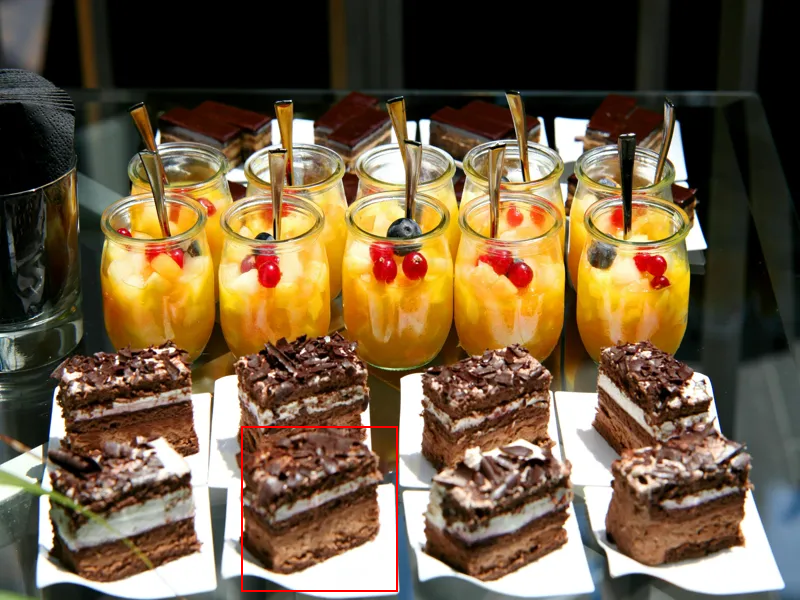

Question: Write a very detial introduciton about the object in bounding box {{bbox}}
us.amazon.nova-lite-v1:0 response
A close-up view of a chocolate cake with white cream and chocolate shavings on top, placed on a white plate. The cake is sliced into two pieces, and the top slice has a small amount of white cream on it. The cake is placed on a glass table, and there are other desserts on the table, including a glass jar with a spoon and a glass cup with a spoon.


In [13]:
prompts = "Write a very detial introduciton about the object in bounding box {{bbox}}"
bbox = (241, 426, 397, 591)

caption(
    prompts=prompts,
    image_path="test_images/cakes.webp", 
    bbox=bbox,
)

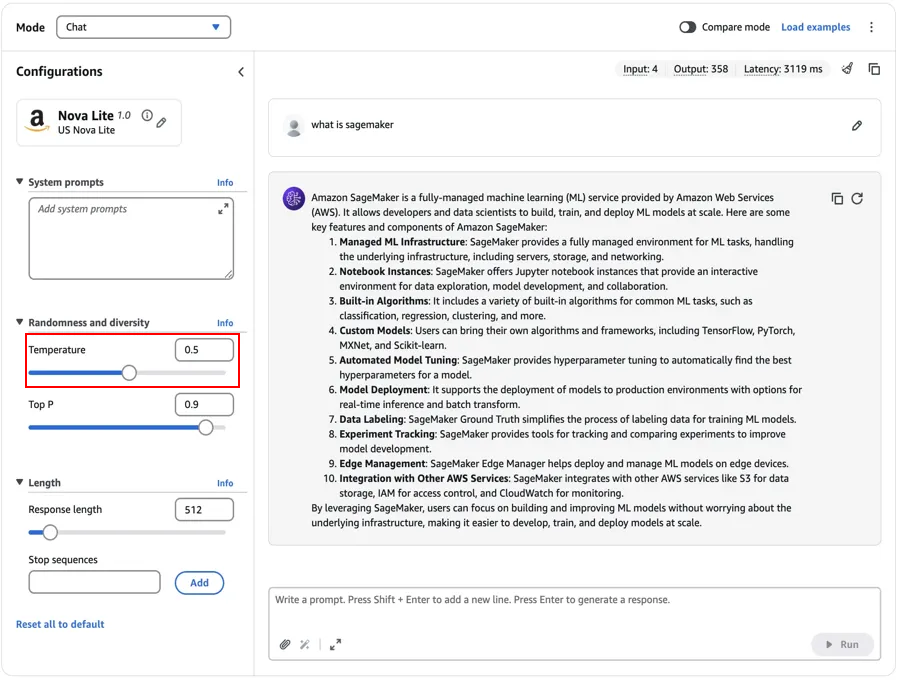

Question: What is the component and the value in bounding box {{bbox}}
us.amazon.nova-lite-v1:0 response
Temperature slider. The value is 0.5.


In [11]:
prompts = "What is the component and the value in bounding box {{bbox}}"
bbox = (25, 333, 239, 387)
caption(
    prompts=prompts,
    image_path="test_images/bedrock_playground_screenshot.webp", 
    bbox=bbox,
)


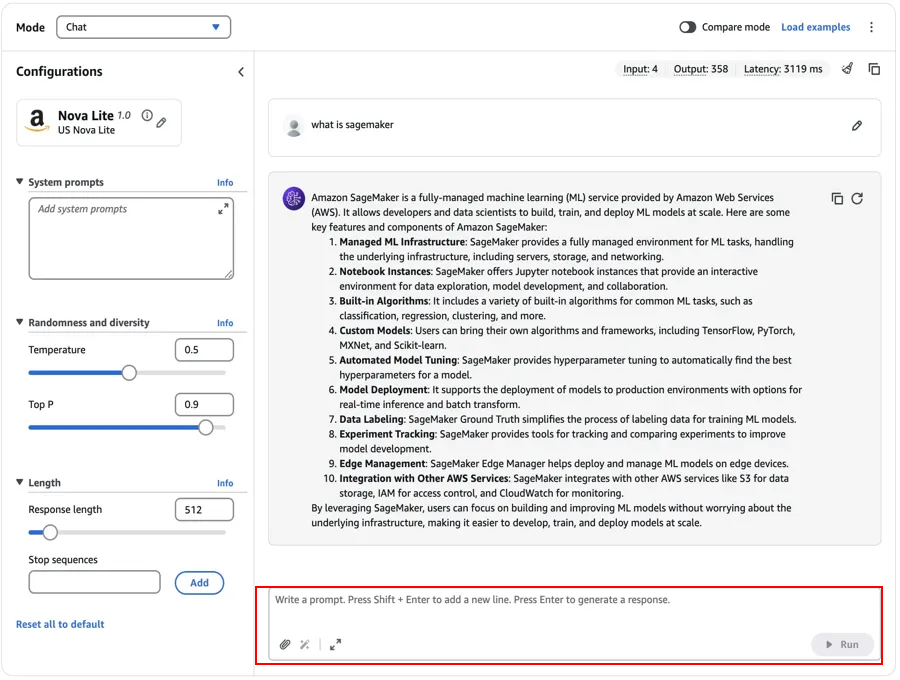

Question: What is the component in bounding box {{bbox}}, describe the function
us.amazon.nova-lite-v1:0 response
This is a text box where you can input a prompt to generate a response. The prompt is used as input for the model to generate a response based on the given prompt. The response is then displayed in the text box. The text box also includes a button to add a new line to the prompt and a button to generate a response. The response is generated based on the input prompt and the model's understanding of the prompt. The response can be used for various purposes, such as generating text, answering questions, or providing information.


In [12]:
prompts = "What is the component in bounding box {{bbox}}, describe the function"
bbox = (255, 586, 882, 664)

caption(
    prompts=prompts,
    image_path="test_images/bedrock_playground_screenshot.webp", 
    bbox=bbox,
)